# Forecasting flight delays
## Reading the data
Features discription:
- Month, DayofMonth, DayOfWeek - month, day of month, day of week
- DepTime - departure time
- UniqueCarrier - carrier code
- Origin - place of departure
- Dest - place of destination
- Distance - distance between airports
- dep_delayed_15min - delay of departure by 15 minutes or more (target sign)

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [78]:
train_data = pd.read_csv("data/flight_delays_train.csv")
train_data.index.names = ['id']
train_data.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
id,,,,,,,,,
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [79]:
train_df = train_data.copy()

In [80]:
test_data = pd.read_csv("data/flight_delays_test.csv")
test_data.index.names = ['id']
test_df = test_data.copy()
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
id,,,,,,,,
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


## EDA
### Data analysis

In [81]:
train_df["delayed"] = train_df["dep_delayed_15min"].apply(lambda v: int(v == 'Y'))
train_df.drop(columns=['dep_delayed_15min'], inplace=True)

In [82]:
cat_columns = train_df.select_dtypes("object").columns
for column in cat_columns:
    print(f"{column}: {train_df[column].nunique()}")

Month: 12
DayofMonth: 31
DayOfWeek: 7
UniqueCarrier: 22
Origin: 289
Dest: 289


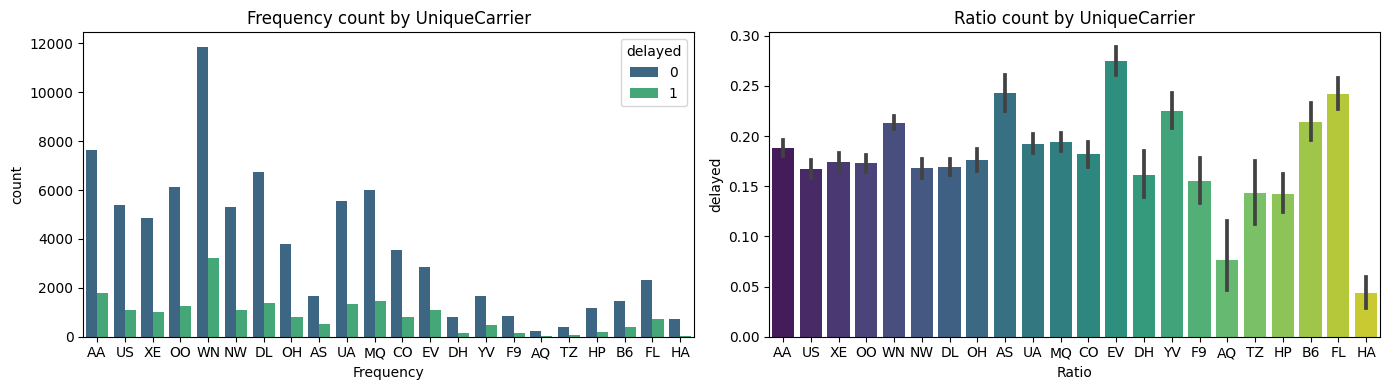

In [83]:
column = "UniqueCarrier"
# Create a bar plot for each categorical column
plt.figure(figsize=(14, 4))
# fig, axes = plt.subplots(1, 2, sharex=True, figsize=(14, 4))

# count plot divided by delayed feature
plt.subplot(1, 2, 1)
sns.countplot(data=train_df, x=column, hue="delayed", palette="viridis") #, ax=axes[0])
# axes[0].xticks(rotation=45)
plt.xlabel("Frequency")
plt.title(f"Frequency count by {column}")

# Ratio of delays to the total number of flights
plt.subplot(1, 2, 2)
sns.barplot(data=train_df, x=column, y="delayed", palette="viridis") #, ax=axes[1])
# axes[1].xticks(rotation=45)
plt.xlabel("Ratio")
plt.title(f"Ratio count by {column}")

plt.tight_layout()
# plt.show()

### Transforming data

In [84]:
for _df in [train_df, test_df]:
    for column in ["Month", "DayofMonth", "DayOfWeek"]:
        _df[column] = _df[column].apply(lambda code: int(code[2:]))

In [85]:
label_encoder = LabelEncoder()

for column in cat_columns:
    unique_values = set(train_df[column]) | set(test_df[column])
    label_encoder.fit(list(unique_values))
    
    train_df[column] = label_encoder.transform(train_df[column])
    test_df[column] = label_encoder.transform(test_df[column])

In [86]:
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,delayed
id,,,,,,,,,
0,7,20,6,1934,1,19,82,732,0
1,3,19,2,1548,19,226,180,834,0
2,8,1,4,1422,21,239,62,416,0
3,10,24,5,1015,16,81,184,872,0
4,9,6,5,1828,20,182,210,423,1


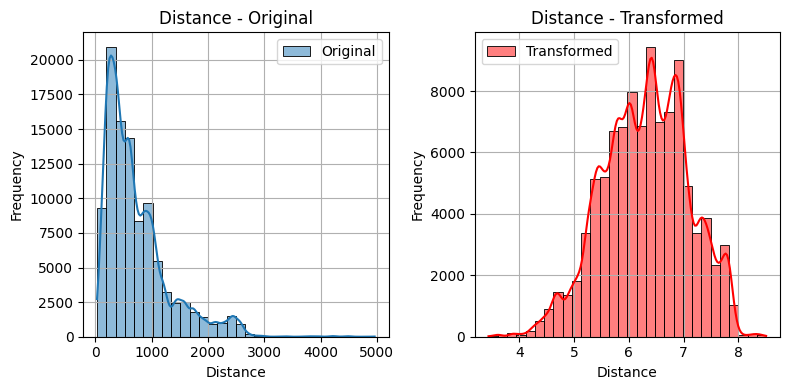

In [87]:
from sklearn.preprocessing import StandardScaler

X = train_df.drop(columns=['delayed'])
y = train_df['delayed']

X_original = X.copy()

# Apply log scaling to Distance feature
X['Distance'] = np.log1p(X['Distance'])
test_df['Distance'] = np.log1p(test_df['Distance'])

# Standartize the entire feature matrix X
scaler = StandardScaler()
X_data = scaler.fit_transform(X)
test_df = scaler.transform(test_df)

# Looking at transformed Distance feature
feature = 'Distance'
plt.figure(figsize=(8, 4))

# Original data
plt.subplot(1, 2, 1)
sns.histplot(X_original[feature], bins=30, kde=True, label='Original')
plt.title(f"{feature} - Original")
plt.xlabel(feature)
plt.ylabel("Frequency")
plt.legend()
plt.grid()

# Transformed data
plt.subplot(1, 2, 2)
sns.histplot(X[feature], bins=30, color='red', kde=True, label='Transformed')
plt.title(f"{feature} - Transformed")
plt.xlabel(feature)
plt.ylabel("Frequency")
plt.legend()
plt.grid()

plt.tight_layout()

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(80000, 8) (20000, 8) (80000,) (20000,)


## Machine learning
### Selecting the best ML model
#### Decision tree

In [89]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

##### Train data

In [90]:
# dt_clf = GridSearchCV(
#     DecisionTreeClassifier(random_state=42),
#     {
#         "max_depth": range(1, 16),
#         "criterion": ["gini", "entropy", "log_loss"],
#     },
#     cv=5,
#     n_jobs=-1,
#     verbose=2,
# )

# dt_clf.fit(X_train, y_train)

# print(dt_clf.best_score_, dt_clf.best_estimator_)

In [91]:
dt = DecisionTreeClassifier(max_depth=7, random_state=42)
dt.fit(X_train, y_train)

print(accuracy_score(y_train, dt.predict(X_train)),
      accuracy_score(y_test, dt.predict(X_test)))

0.8154 0.8145


##### Test data

In [97]:
pd.DataFrame(
    pd.Series(dt.predict(test_df), index=test_data.index),
    index=test_data.index,
    columns=['dep_delayed_15min'],
).to_csv('predictions_dt.csv')

#### Random forest

In [98]:
from sklearn.ensemble import RandomForestClassifier

##### Train data

In [ ]:
rf_clf = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100),
    {
        "max_depth": range(1, 16),
        "criterion": ["gini", "entropy"]
    }
)